In [1]:
!git clone https://github.com/nlpcuom/Sinhala-POS-Data.git

fatal: destination path 'Sinhala-POS-Data' already exists and is not an empty directory.


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

sys.path.append('..')

In [4]:
import re
import os
from string import printable

from itertools import chain
import importlib
from tqdm import tqdm

import nltk
import sklearn
import joblib
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import sinling
from sinling import SinhalaTokenizer, SinhalaStemmer

stemmer = SinhalaStemmer()

%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [6]:
sentences = []
tokens = []
for line in list(open('Sinhala-POS-Data/news- verified- final level.txt', 'r', encoding='utf-8')):
    if len(line.strip()) == 0:
        continue
    parts = re.split(' +', line.replace(u'\xa0', u' ').strip())
    if len(parts) != 2:
        # print(f'Error in line: {line}, sized {len(parts)} having parts {parts}')
        continue
    word, tag = ' '.join(parts[:-1]).strip().encode('utf-8').decode('utf-8'), ''.join([ch for ch in parts[-1].strip().strip('[') if ch in printable])
    # word = word.replace(u'\u200d', u'')
    tokens.append((word, tag))
    if parts[-1] == 'FS':
        sentences.append(tokens)
        tokens = []

In [7]:
%%time
train_sents = sentences[:8000]
test_sents = sentences[8000:]

print(len(train_sents), len(test_sents))
print()

8000 3294

CPU times: user 1.03 ms, sys: 84 µs, total: 1.11 ms
Wall time: 1.07 ms


In [10]:
def word2features(sent, i):
    word = sent[i][0]
    stem, suff = stemmer.stem(word)
    features = {
        'bias': 1.0,
        word: True,
        f'STEM': stem,
        f'SUFF': suff,
        'len(word)': len(word),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word_prev = sent[i-1][0]
        features.update({
            f'-1:word': word_prev,
            '-1:word.isdigit()': word_prev.isdigit(),
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word_next = sent[i+1][0]
        features.update({
            f'+1:word': word_next,
            '+1:word.isdigit()': word_next.isdigit(),
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

In [11]:
%%time
x_train, y_train = [], []
for s in tqdm(train_sents):
    x_train.append(sent2features(s))
    y_train.append(sent2labels(s))

x_test, y_test = [], []
for s in tqdm(test_sents):
    x_test.append(sent2features(s))
    y_test.append(sent2labels(s))

100%|██████████| 3294/3294 [00:00<00:00, 5604.80it/s]

CPU times: user 1.98 s, sys: 79.4 ms, total: 2.06 s
Wall time: 2.22 s


In [25]:
TRAIN = True

if TRAIN:
    # define fixed parameters and parameters to search
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.4730949450810971,
        c2=0.03983665956083338,
        max_iterations=100,
        all_possible_transitions=True
    )
    crf.fit(x_train, y_train)
    joblib.dump(crf, '../resources/pos-tagger-crf-sinling.joblib')
    
model = joblib.load('../resources/pos-tagger-crf-sinling.joblib')

In [26]:
if TRAIN:
    labels = list(model.classes_)
    
    print(labels)
    
    y_pred = model.predict(x_test)
    
    metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)
    
    print(metrics.flat_classification_report(
        y_test, y_pred, labels=labels, digits=3
    ))

['NNP', 'NNJ', 'NNC', 'CM', 'NUM', 'RP', 'RRPCV', 'VFM', 'FS', 'NCV', 'VP', 'DET', 'VNF', 'NIP', 'JJ', 'NVB', 'PRP', 'VNN', 'RB', 'POST', 'CC', 'JCV', 'NDT', 'PUNC', 'ABB', 'AUX', 'QUE', 'QBE', 'UNK', 'VVF', 'UH', 'NNp', 'NN', 'VNP', 'FSS']
              precision    recall  f1-score   support

         NNP      0.761     0.652     0.703      5297
         NNJ      0.617     0.547     0.580      1727
         NNC      0.839     0.874     0.856     18038
          CM      0.976     0.961     0.969       512
         NUM      0.938     0.859     0.897      1399
          RP      0.972     0.976     0.974      2311
       RRPCV      0.854     0.838     0.846       870
         VFM      0.857     0.920     0.887      1709
          FS      1.000     1.000     1.000      3294
         NCV      0.755     0.729     0.742      1053
          VP      0.885     0.895     0.890      4818
         DET      0.977     0.967     0.972      1780
         VNF      0.862     0.829     0.845      3008
  

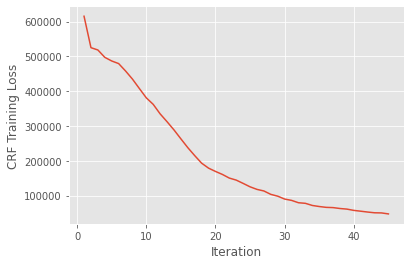

In [15]:
x = [t['num'] for t in model.training_log_.iterations]
y = [t['loss'] for t in model.training_log_.iterations]
plt.plot(x, y)
plt.ylabel('CRF Training Loss')
plt.xlabel('Iteration')
plt.show()

In [21]:
def test_document(document):
    tokenizer = SinhalaTokenizer()

    test_sentences = tokenizer.split_sentences(document)
    
    for sentence in test_sentences:
        tokens = tokenizer.tokenize('%s.' % sentence)
        pos_tags = model.predict([sent2features([(t, None) for t in tokens])])
        print(list(zip(tokens, pos_tags[0])))
        print()

test_document(
    'මනුෂ්‍යයා අවුරුදු ලක්ෂ ගණනක සිට වෛරස් වසංගත නිසා එළිපිටම පීඩා විඳි සත්වයෙකි. ' \
    'ඇතැම් වෛරස් රෝග වලට වැක්සීන හෙවත් එන්නත් ද වෛරස් නාශක ඖෂධ ද තිබුනද සියලූ‍ වෛරස් ' \
    'සම්බන්ධයෙන් ඒ න්‍යාය වැඩ කරන්නේ නැත. වසූරිය වෛරසය මිනිසා විසින් මිහිමතින් තුරන් කර තිබේ.'
)

[('මනුෂ්\u200dයයා', 'NNC'), ('අවුරුදු', 'NNC'), ('ලක්ෂ', 'NUM'), ('ගණනක', 'NNC'), ('සිට', 'POST'), ('වෛරස්', 'NNP'), ('වසංගත', 'NNC'), ('නිසා', 'POST'), ('එළිපිටම', 'NNC'), ('පීඩා', 'NNC'), ('විඳි', 'VP'), ('සත්වයෙකි', 'NVB'), ('.', 'FS')]

[('ඇතැම්', 'DET'), ('වෛරස්', 'JJ'), ('රෝග', 'NNC'), ('වලට', 'CM'), ('වැක්සීන', 'NNC'), ('හෙවත්', 'CC'), ('එන්නත්', 'NNC'), ('ද', 'RP'), ('වෛරස්', 'NNC'), ('නාශක', 'JJ'), ('ඖෂධ', 'NNC'), ('ද', 'RP'), ('තිබුනද', 'NNC'), ('සියලූ\u200d', 'JJ'), ('වෛරස්', 'NNC'), ('සම්බන්ධයෙන්', 'POST'), ('ඒ', 'DET'), ('න්\u200dයාය', 'JJ'), ('වැඩ', 'NNC'), ('කරන්නේ', 'VP'), ('නැත', 'NIP'), ('.', 'FS')]

[('වසූරිය', 'NNC'), ('වෛරසය', 'NNC'), ('මිනිසා', 'NNC'), ('විසින්', 'POST'), ('මිහිමතින්', 'NNC'), ('තුරන්', 'RRPCV'), ('කර', 'VNF'), ('තිබේ', 'VFM'), ('.', 'FS')]



In [22]:
MODEL_SELECTION = 1

if MODEL_SELECTION:
    # define fixed parameters and parameters to search
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        max_iterations=100,
        all_possible_transitions=True
    )
    
    params_space = {
        'c1': scipy.stats.expon(scale=0.5),
        'c2': scipy.stats.expon(scale=0.05),
    }
    
    # use the same metric for evaluation
    f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)
    
    # search
    rs = RandomizedSearchCV(crf, params_space,
                            cv=5,
                            verbose=10,
                            n_jobs=-1,
                            n_iter=10,
                            scoring=f1_scorer)
    
    print('best params:', rs.best_params_)
    print('best CV score:', rs.best_score_)
    print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/yasas/Documents/Projects/ysenarath/sinling/venv/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 28.7min finished


best params: {'c1': 0.4730949450810971, 'c2': 0.03983665956083338}
best CV score: 0.8878221398017775
model size: 3.21M


AttributeError: 'str' object has no attribute 'parameters'